In [1]:
import numpy as np; import matplotlib.pyplot as plt
from matplotlib import colors
import random
import scipy
from scipy.integrate import solve_ivp

import sympy as sym
sym.init_printing()

In [2]:
#Symbol definitions
N = sym.symbols("N") 
P = sym.symbols("P") 
V = sym.symbols("V") 

N_n = sym.symbols("N_n") 
N_r = sym.symbols("N_r") 
P_s = sym.symbols("P_s") 
P_i = sym.symbols("P_i") 
Z  = sym.symbols("Z") 
V_i = sym.symbols("V_i") 
V_e = sym.symbols("V_e") 

V_max     = sym.symbols("V_max") # Maximum phytoplankton growth rate,
γ_Z       = sym.symbols("γ_Z")  # Growth rate / Assimilation frequency 
φ         = sym.symbols("φ")    # Viral adsorption rate, ml / (NT * day), Table S1
g         = sym.symbols("g")    # Maximum specific grazing rate

ν_x       = sym.symbols("ν_x")  # Proportion of nutrients originating 
                                # from virus in host-virus pair
ν_i       = sym.symbols("ν_i")  # lysis rate tune

λ_P       = sym.symbols("λ_P")  # Mortality & Respiration rate
λ_Z       = sym.symbols("λ_Z")  # Linear mortality & respiration & egestion
λ_Z_hat   = sym.symbols("\hat{λ}_Z") # Quadratic mortality & respiration & egestion
λ_E       = sym.symbols("λ_E")  # Mortality 
δ         = sym.symbols("δ ")   # Host lysis rate

μ_P       = sym.symbols("μ_P")  # Remineralization fraction due to mortality
μ_V       = sym.symbols("μ_V")  # Max host NT recycling rate 
μ_V_prime = sym.symbols("μ'_V") # Max de novo NT synthesis rate
μ_delta   = sym.symbols("μ_delta") # Remineralization fraction due to lysis
μ_g       = sym.symbols("μ_g")  # Remineralization fraction due to sloppy-eating
μ_Z       = sym.symbols("μ_Z")  # Remineralization fraction due to mortality
μ_m       = sym.symbols("μ_m")  # Fraction of V_i which rejoins the V_e pop after host mortality

K_N       = sym.symbols("K_N")  # Half-saturation constant for nutrient limitation
K_I       = sym.symbols("K_I")  # Half-saturation for light limitation
K_Z       = sym.symbols("K_Z")  # Half-saturation for ... ?
K_P       = sym.symbols("K_P")  # Half-saturation constant for grazing of P
I_0       = sym.symbols("I_0")  # Compensation irradiance

ω         = sym.symbols("ω") 

In [4]:
#Defining equations of coupled model
P = P_s + P_i

N = N_n + N_r

V = V_i + V_e

nutr_lim = N / (K_N + N)

light_lim = 1 #light limitation term

adsorption = φ * P_s * V_e 
P_growth   = V_max * nutr_lim * light_lim
grazing    = g * Z / K_P
P_mort     = λ_P
lysis_rate = δ * ν_i

nt_recycling = ν_i * μ_V

#Phytoplankton suseptible
P_s_dt = P_s * (P_growth - grazing - P_mort - ω) - ((1 - ν_x) * adsorption)

#Phytoplankton infected
nt_recycling = ν_i * μ_V

P_i_dt = P_i * (P_growth - grazing - P_mort - nt_recycling - lysis_rate - ω) \
         + (1 - ν_x) * adsorption

#Zooplankton
assimilation = γ_Z * g * (P + V_i) / K_P
Z_mort = λ_Z + λ_Z_hat * Z

Z_dt = Z * (assimilation - Z_mort - ω)


#Intracellular viruses
V_i_growth  = ν_i * (μ_V + μ_V_prime) * P_i

V_i_dt = V_i_growth + ν_x * adsorption - V_i * (lysis_rate + grazing + P_mort + ω)

#Extracellular
V_e_mort = λ_E

V_e_dt = - ν_x * adsorption + V_i * (lysis_rate + μ_m * P_mort) - V_e * (V_e_mort + ω) 

#Nitrate
denovo_synthesis = ν_i * μ_V_prime * P_i

N_n_dt = - N_n / N * (P * P_growth + denovo_synthesis) - N_n * ω

#Recycled nutrients
sloppy_eating = (1 - γ_Z) * (P + V_i) * grazing
mortality = P_mort * (P + (1 - μ_m) * V_i) 

remin  = - N_r / N * (P * P_growth + denovo_synthesis) + μ_P * mortality + V_e_mort * V_e + \
         μ_delta * (P_i * lysis_rate) + μ_g * sloppy_eating + μ_Z * (Z * Z_mort) - (N_r * ω)

export = (1 - μ_P) * mortality + (1 - μ_delta) * (P_i * lysis_rate) + \
         (1 - μ_g) * sloppy_eating + (1 - μ_Z) * (Z * Z_mort)

N_r_dt = remin + export

In [ ]:
#Steady-State solution?
#Putting the equations into matrix form
var = [P_s, P_i, Z, V_i, V_e, N_n, N_r]

#Susceptiple pop eq
li_P_s = sym.Matrix([- λ_P - ω, 0, -g * P_s / K_P, 0, - (1 - ν_x) * φ * P_s,
          (P_s * V_max) / (K_N + N), (P_s * V_max) / (K_N + N)])

#eq_P_s = sum(li_P_s[i] * var[i] for i in range(len(var))) 
#display(sym.simplify(eq_P_s - P_s_dt) == 0)

#Infected pop eq
li_P_i = sym.Matrix([(1 - ν_x) * φ * V_e, - λ_P -  ν_i * μ_V - ν_i * δ - ω, 
          -g * P_i / K_P, 0, 0, P_i * V_max / (K_N + N), P_i * V_max / (K_N + N)])

#eq_P_i = sum(li_P_i[i] * var[i] for i in range(len(var))) 
#display(sym.simplify(eq_P_i - P_i_dt) == 0)

#Zooplankton
li_Z = sym.Matrix([Z * γ_Z * g/K_P, Z * γ_Z * g/K_P, - (λ_Z + λ_Z_hat * Z) - ω, Z * γ_Z * g/K_P, 0, 0, 0])

#eq_Z = sum(li_Z[i] * var[i] for i in range(len(var))) 
#display(sym.simplify(eq_Z - Z_dt) == 0)

#Intracellular Virus
li_V_i = sym.Matrix([ν_x * φ * V_e, ν_i * (μ_V + μ_V_prime), - V_i * g / K_P, - ν_i * δ - λ_P - ω, 0, 0, 0])

#eq_V_i = sum(li_V_i[i] * var[i] for i in range(len(var))) 
#display(sym.simplify(eq_V_i - V_i_dt) == 0)

#Extracellular virus
li_V_e = sym.Matrix([- ν_x * φ * V_e, 0, 0, ν_i * δ + μ_m * λ_P, - λ_E - ω, 0, 0])

#eq_V_e = sum(li_V_e[i] * var[i] for i in range(len(var))) 
#display(sym.simplify(eq_V_e - V_e_dt) == 0)

#Nooch 
li_N_n = sym.Matrix([0, - (N_n /N) * ν_i * μ_V_prime, 0, 0, 0, - (P / N) * (V_max * N / (K_N + N)) - ω, 0])

#eq_N_n = sum(li_N_n[i] * var[i] for i in range(len(var))) 
#display(sym.simplify(eq_N_n - N_n_dt) == 0)

#lumped remin and export together for initial simplicity
li_N_r = sym.Matrix([λ_P, - (N_r / N) * ν_i * μ_V_prime + λ_P + ν_i * δ, 
          (1 - γ_Z) * g * (P + V_i) / K_P + (λ_Z + λ_Z_hat * Z), 
          λ_P * (1 - μ_m), λ_E, 0, - (P / N) * (V_max * N / (K_N + N)) - ω])

#eq_N_r = sum(li_N_r[i] * var[i] for i in range(len(var))) 
#display(sym.simplify(eq_N_r - N_r_dt) == 0)

system = sym.Matrix([[li_P_s, li_P_i, li_Z, li_V_i, li_V_e, li_N_n, li_N_r]])
#display(system)

equations = [P_s_dt, P_i_dt, Z_dt, V_i_dt, V_e_dt, N_n_dt, N_r_dt]
sym.nonlinsolve(equations, var)

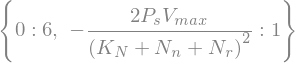

In [49]:
J_P_s = li_P_s.jacobian(var)
E_P_s = J_P_s.eigenvals()
E_P_s

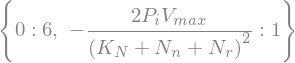

In [50]:
J_P_i = li_P_i.jacobian(var)
E_P_i = J_P_i.eigenvals()
E_P_i

In [51]:
J_Z = li_Z.jacobian(var)
E_Z = J_Z.eigenvals()
E_Z

In [52]:
J_V_i = li_V_i.jacobian(var)
E_V_i = J_V_i.eigenvals()
E_V_i

In [53]:
J_V_e = li_V_e.jacobian(var)
E_V_e = J_V_e.eigenvals()
E_V_e

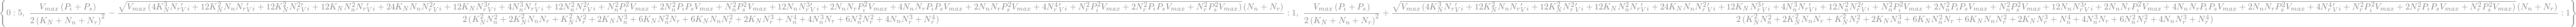

In [54]:
J_N_n = li_N_n.jacobian(var)
E_N_n = J_N_n.eigenvals()
E_N_n

For the N regime to apply to P_s, N must be less than:


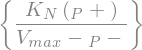

For the N regime to apply to P_i, N must be less than:


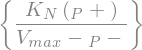

In [14]:
#Solve for N Threshold

#N_T = N, P = Z = V = 0
#Substitute in appropriate values for 0 state variables
N_P_s = P_s_dt.subs([(Z, 0), (V_i, 0), (V_e, 0)])            
N_P_i = P_i_dt.subs([(Z, 0), (V_i, 0), (V_e, 0)])

#Chekcing susceptible pop
print("For the N regime to apply to P_s, N must be less than:")
display(sym.solveset(N_P_s, N).args[0])

#Checking infected pop
print("For the N regime to apply to P_i, N must be less than:")
display(sym.solveset(N_P_i, N).args[0])

#looks familiar...

To sustain the V_i population, P_i must be at least:


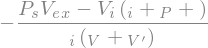


To sustain the V_i population, P_s must be at least:


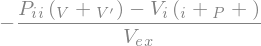


To sustain the V_e population, P_s must be at least:


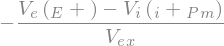


To sustain the Z population, (P_s + P_i + V_i) must be at least:


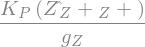

In [55]:
#We need population thresholds to sustain V and Z
#Solve of P threshold for both assuming the other doesn't exist yet...?

NP_V_i = V_i_dt.subs([(Z, 0)]) 
print("To sustain the V_i population, P_i must be at least:")
display(sym.solveset(NP_V_i, P_i).args[0])
print()

print("To sustain the V_i population, P_s must be at least:")
display(sym.solveset(NP_V_i, P_i).args[0])
print()

NP_V_e = V_e_dt.subs([(Z, 0)])
print("To sustain the V_e population, P_s must be at least:")
display(sym.solveset(NP_V_e, P_s).args[0])
print()

print("To sustain the Z population, (P_s + P_i + V_i) must be at least:")
display(sym.solveset(Z_dt, P_s + P_i + V_i).args[0])
